In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

In [36]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

In [3]:
tmp = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

median_rating = tmp['averageRating'].median()

In [4]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


tmp = tmp.sort_values(by='Movie release date')
tmp['ReleaseYearRange'] = tmp['Movie release date'].apply(lambda x: create_range(x))

In [5]:
display(tmp)

ordering  Wikipedia movie ID       Movie name  \
IMDb_ID   IMDb_actor_ID                                                  
tt0021307 nm0862546             1              142852   The Rogue Song   
tt0174450 nm2019593             1            23919691   Africa Speaks!   
tt0021057 nm0002050             1            34383684   Leathernecking   
tt0020640 nm0000050             1               45224  Animal Crackers   
tt0021110 nm0427231             1            10339194            Mammy   
...                           ...                 ...              ...   
tt2379653 nm2054897             1            35646163                3   
          nm2054897             1            35646163                3   
          nm2054897             1            35646163                3   
tt1329232 nm0001097             1            35243445  St George's Day   
tt2220560 nm2319565             1            34809788       Nuvva Nena   

                         Movie release date         primaryName birthYear  \
IMDb_ID   IMDb_actor_ID                                                     
tt0021307 nm0862546                    1930    Lawrence Tibbett      1896   
tt0174450 nm2019593                    1930       Harald Austin      <NA>   
tt0021057 nm0002050                    1930         Irene Dunne      1898   
tt0020640 nm0000050                    1930        Groucho Marx      1890   
tt0021110 nm0427231                    1930           Al Jolson      1886   
...                                     ...                 ...       ...   
tt2379653 nm2054897                    2012  Humberto De Vargas      <NA>   
          nm2054897                    2012  Humberto De Vargas      <NA>   
          nm2054897                    2012  Humberto De Vargas      <NA>   
tt1329232 nm0001097                    2012       Charles Dance      1946   
tt2220560 nm2319565                    2012          Sharwanand      1985   

                         awards  nominations  movie_count  movie_count_genre  \
IMDb_ID   IMDb_actor_ID                                                        
tt0021307 nm0862546           0            1            2                  0   
tt0174450 nm2019593           0            0            1                  0   
tt0021057 nm0002050           0            0            1                  1   
tt0020640 nm0000050           0            0            1                  1   
tt0021110 nm0427231           0            0            1                  0   
...                         ...          ...          ...                ...   
tt2379653 nm2054897           0            0            4                  1   
          nm2054897           0            0            4                  1   
          nm2054897           0            0            4                  1   
tt1329232 nm0001097           0            0            3                  3   
tt2220560 nm2319565           0            0            3                  1   

                         genres_b4  IsDrama  isMale  age_at_release  \
IMDb_ID   IMDb_actor_ID                                               
tt0021307 nm0862546              4        0       1              34   
tt0174450 nm2019593              1        0    <NA>            <NA>   
tt0021057 nm0002050              4        0       0              32   
tt0020640 nm0000050              1        0       1              40   
tt0021110 nm0427231              5        1       1              44   
...                            ...      ...     ...             ...   
tt2379653 nm2054897             17        0    <NA>            <NA>   
          nm2054897             17        1    <NA>            <NA>   
          nm2054897             17        1    <NA>            <NA>   
tt1329232 nm0001097              9        0       1              66   
tt2220560 nm2319565             18        0    <NA>              27   

                         averageRating ReleaseYearRange  
IMDb_ID   IMDb_actor_ID              

C:\Users\kelan\AppData\Local\Temp\ipykernel_9852\483717745.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
C:\Users\kelan\AppData\Local\Temp\ipykernel_9852\483717745.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
C:\Users\kelan\AppData\Local\Temp\ipykernel_9852\483717745.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  me.loc[:, 'Category'] = 'mean'
C:\Users\kelan\AppData\Local\Temp\ipykernel_9852\483717745.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
C:\Users\kelan\AppData\Local\Temp\ipykernel_9852\483717745.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
C:\Users\kelan\AppData\Local\Temp\ipykernel_

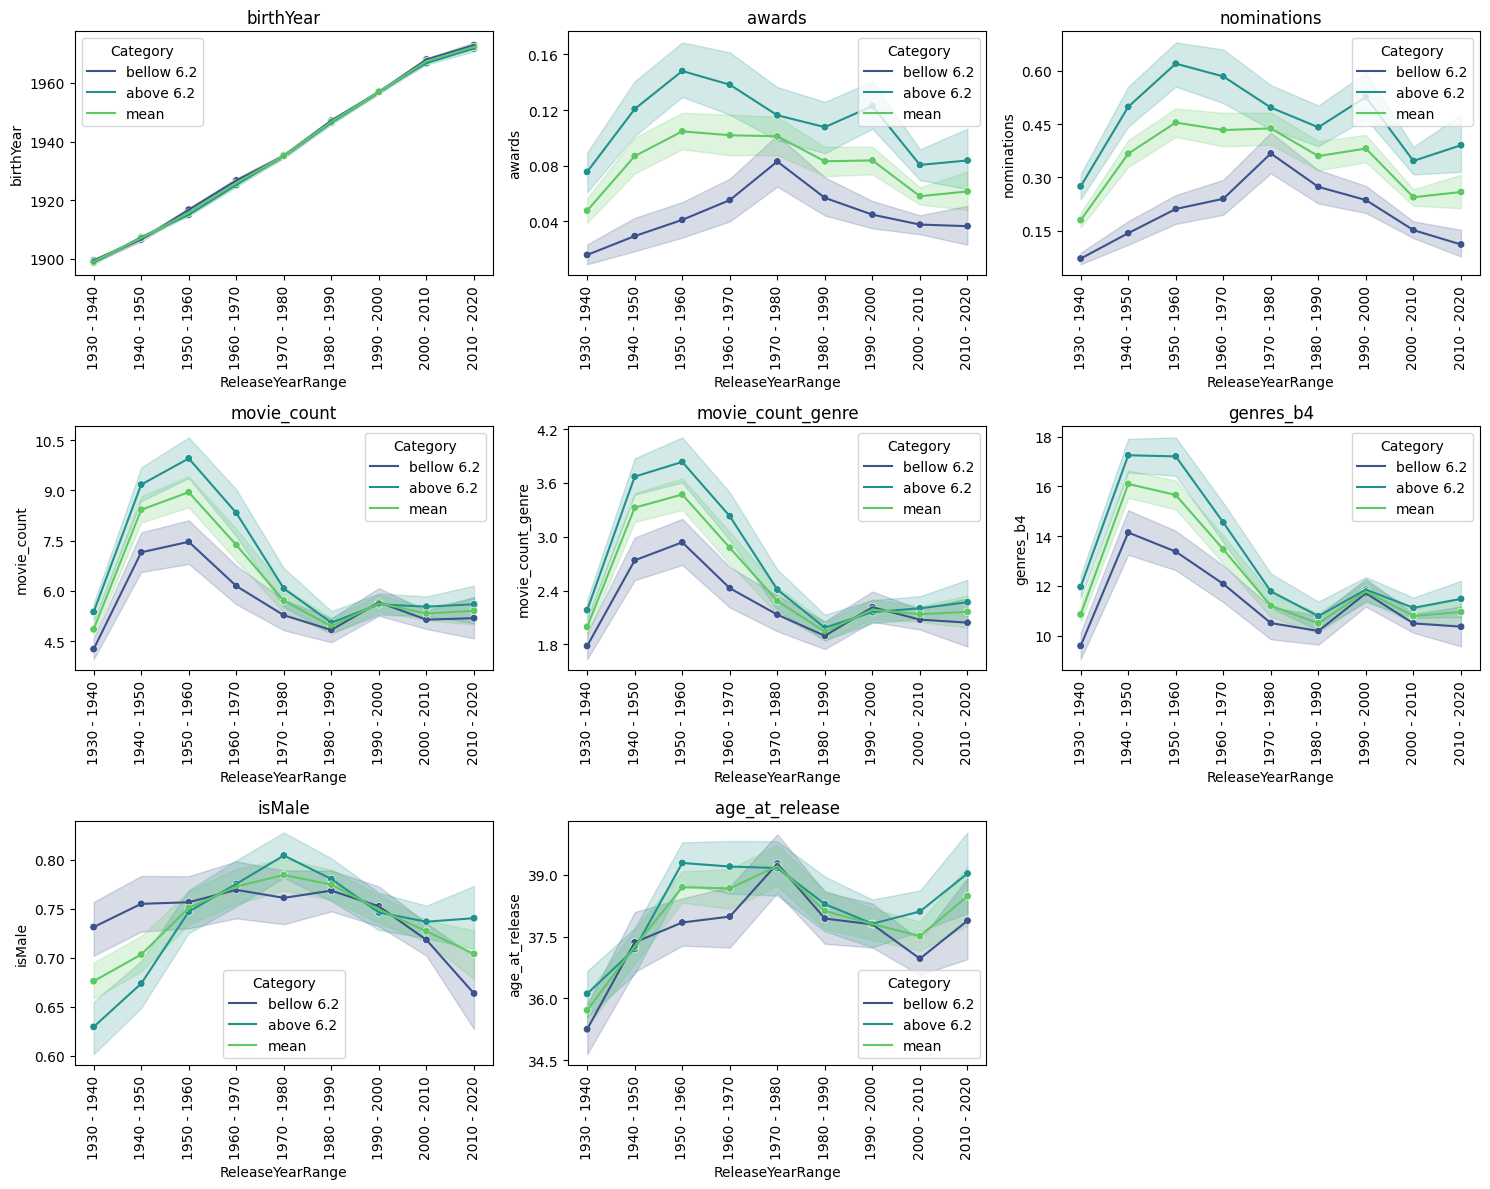

In [6]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    df = df.replace("\\N", pd.NA)

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        me_filtered_mean['Category'] = 'mean'

        frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

do_fancy_ecpi_cute_plot(tmp, 'median_rating', 'averageRating', 'ReleaseYearRange', 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'])

TODO: Add T-tests pour certains trucs par année, p.e en 1950-1960, p= 0.03 entre good grades et bad grades -> significant

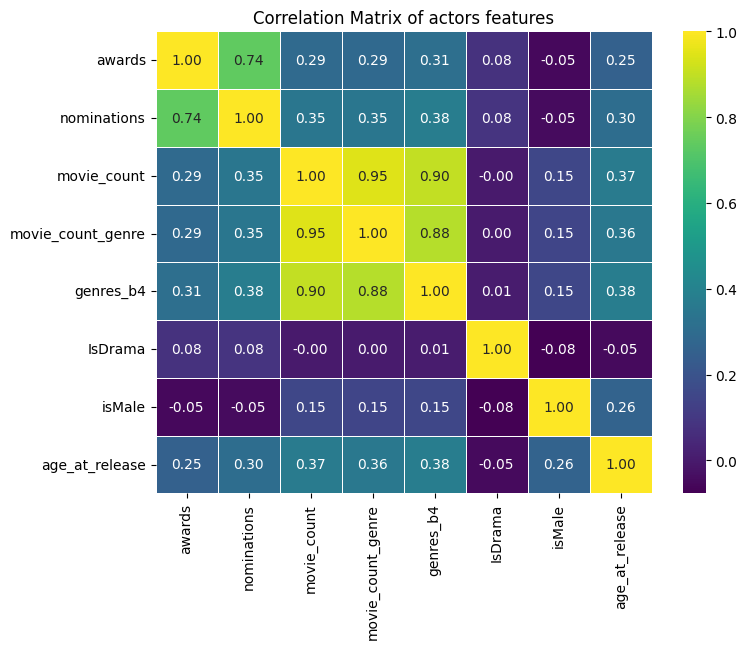

In [7]:
# Calculate the correlation matrix
correlation_matrix = actors['Features'].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

**High correlations**
- 0.95: Movie count vs Movie count in drama 
- 0.90: Movie count vs Genres diversity
- 0.89: Movie count in drama vs Genres diversity
- 0.74: Nominations vs Awards


# We saw from (Dimitri's) graphs, that the awards and nominations seemed to have a large influence on the average film raiting over all years. 
Lets have a look at the correlation

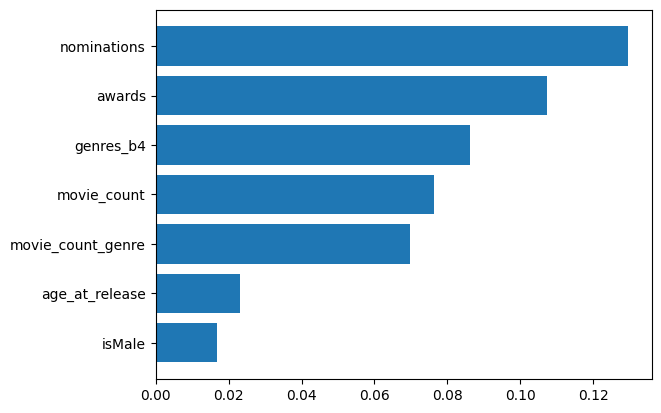

In [8]:
correlation_matrix=tmp[[ 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release','averageRating']].corr()
correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')  # Remove correlation with itself
correlation_with_X_sorted = correlation_with_X.sort_values()
# Create a horizontal bar plot
plt.barh(correlation_with_X_sorted.index, correlation_with_X_sorted)
plt.show()

<Axes: xlabel='awards', ylabel='averageRating'>

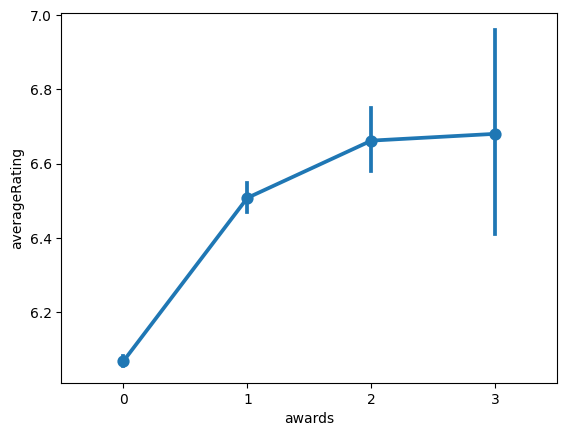

In [9]:
sns.pointplot(x='awards', y='averageRating', data=tmp, errorbar=('ci', 95))

Even though there is a large confidence interval the higher the award count is, we can conclude that actors with oscars do infact play in betrter films.

<Axes: xlabel='nominations', ylabel='averageRating'>

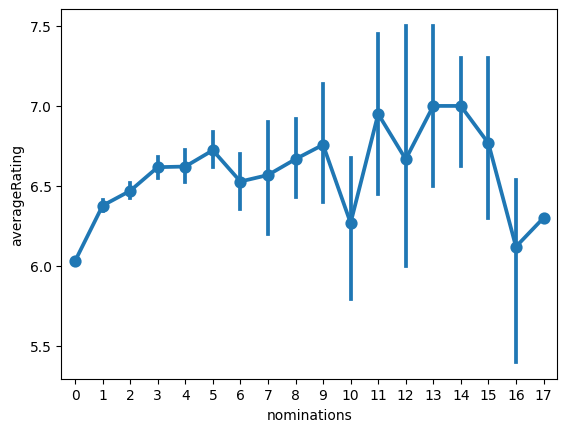

In [10]:
sns.pointplot(x='nominations', y='averageRating', data=tmp, errorbar=('ci', 95))

In [52]:
model = smf.glm(formula='averageRating ~ awards', data=tmp)
fit = model.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          averageRating   No. Observations:                28408
Model:                            GLM   Df Residuals:                    28406
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1259
Method:                          IRLS   Log-Likelihood:                -41993.
Date:                Fri, 15 Dec 2023   Deviance:                       31983.
Time:                        12:16:54   Pearson chi2:                 3.20e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01157
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0694      0.006    934.879      0.0

In [11]:
tmp.reset_index(drop=True, inplace=True) #TODO Peut etre a changer

C:\Users\kelan\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kelan\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


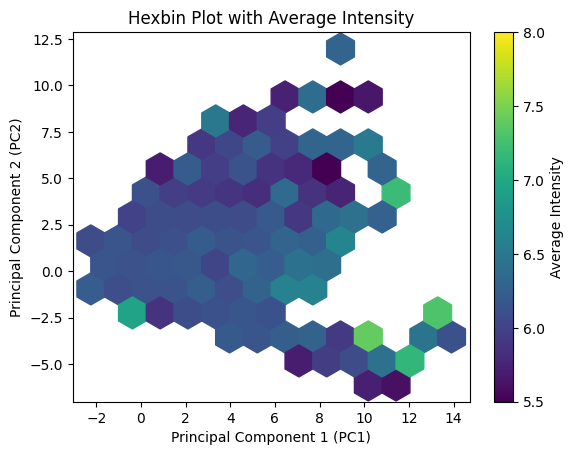

In [12]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(tmp[[ 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release','averageRating']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = tmp[['averageRating']]

# Set custom vmin and vmax values
vmin = 5.5  # minimum value for the color scale
vmax = 8  # maximum value for the color scale

# Create a hexbin plot with average intensity
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=13, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity')
plt.show()

We can see that the right is a bit lighter than the left meaning that there is a difference in actors between good and bad films
#todo -> Same but with hue(+6.2, -6.2)

C:\Users\kelan\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kelan\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


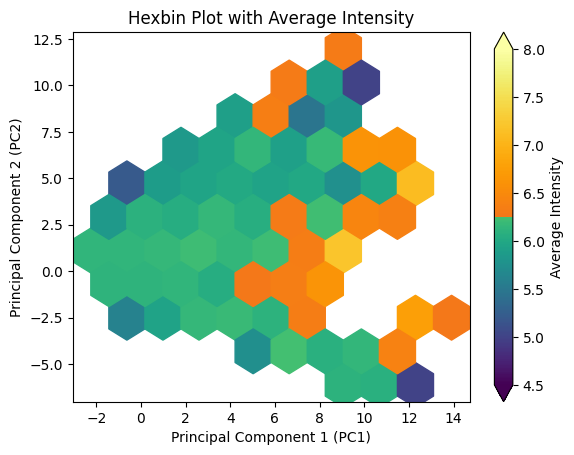

In [34]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(tmp[['awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release', 'averageRating']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = tmp['averageRating']

# Set custom vmin and vmax values
vmin = 4.5  # minimum value for the color scale
vmax = 8    # maximum value for the color scale

# Create a custom colormap
colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)

# Create a hexbin plot with the custom colormap
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity', extend='both')  # Add extend='both' to show color limits beyond the data range
plt.show()

In [13]:
# TODO try and run with UMAP -> doesn't work for me (KS)
# # Standardize the data (important for UMAP)
# scaler = StandardScaler()
# df_standardized = scaler.fit_transform(tmp[[ 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release','averageRating']].dropna())

# # Apply UMAP to reduce to 2 dimensions
# umap_result = UMAP(n_components=2).fit_transform(df_standardized)

# # Create a DataFrame with the UMAP results and the continuous variable
# df_umap = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
# df_umap['Intensity'] = tmp[['averageRating']]

# # Set custom vmin and vmax values
# vmin = 0  # minimum value for the color scale
# vmax = 60  # maximum value for the color scale

# # Create a hexbin plot with custom range
# hexbin = plt.hexbin(df_umap['UMAP1'], df_umap['UMAP2'], C=df_umap['Intensity'], gridsize=20, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('Hexbin Plot with Average Intensity (UMAP)')
# plt.colorbar(hexbin, label='Average Intensity')
# plt.show()

C:\Users\kelan\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kelan\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


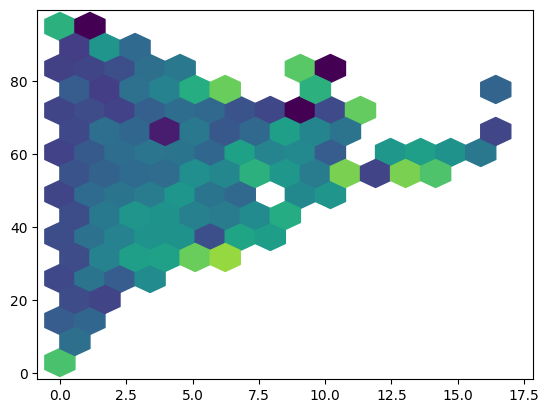

In [14]:
tmp3=tmp.dropna()
plt.hexbin(x=tmp3["nominations"], y=tmp3["age_at_release"], C=tmp3['averageRating'],  gridsize=15, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)

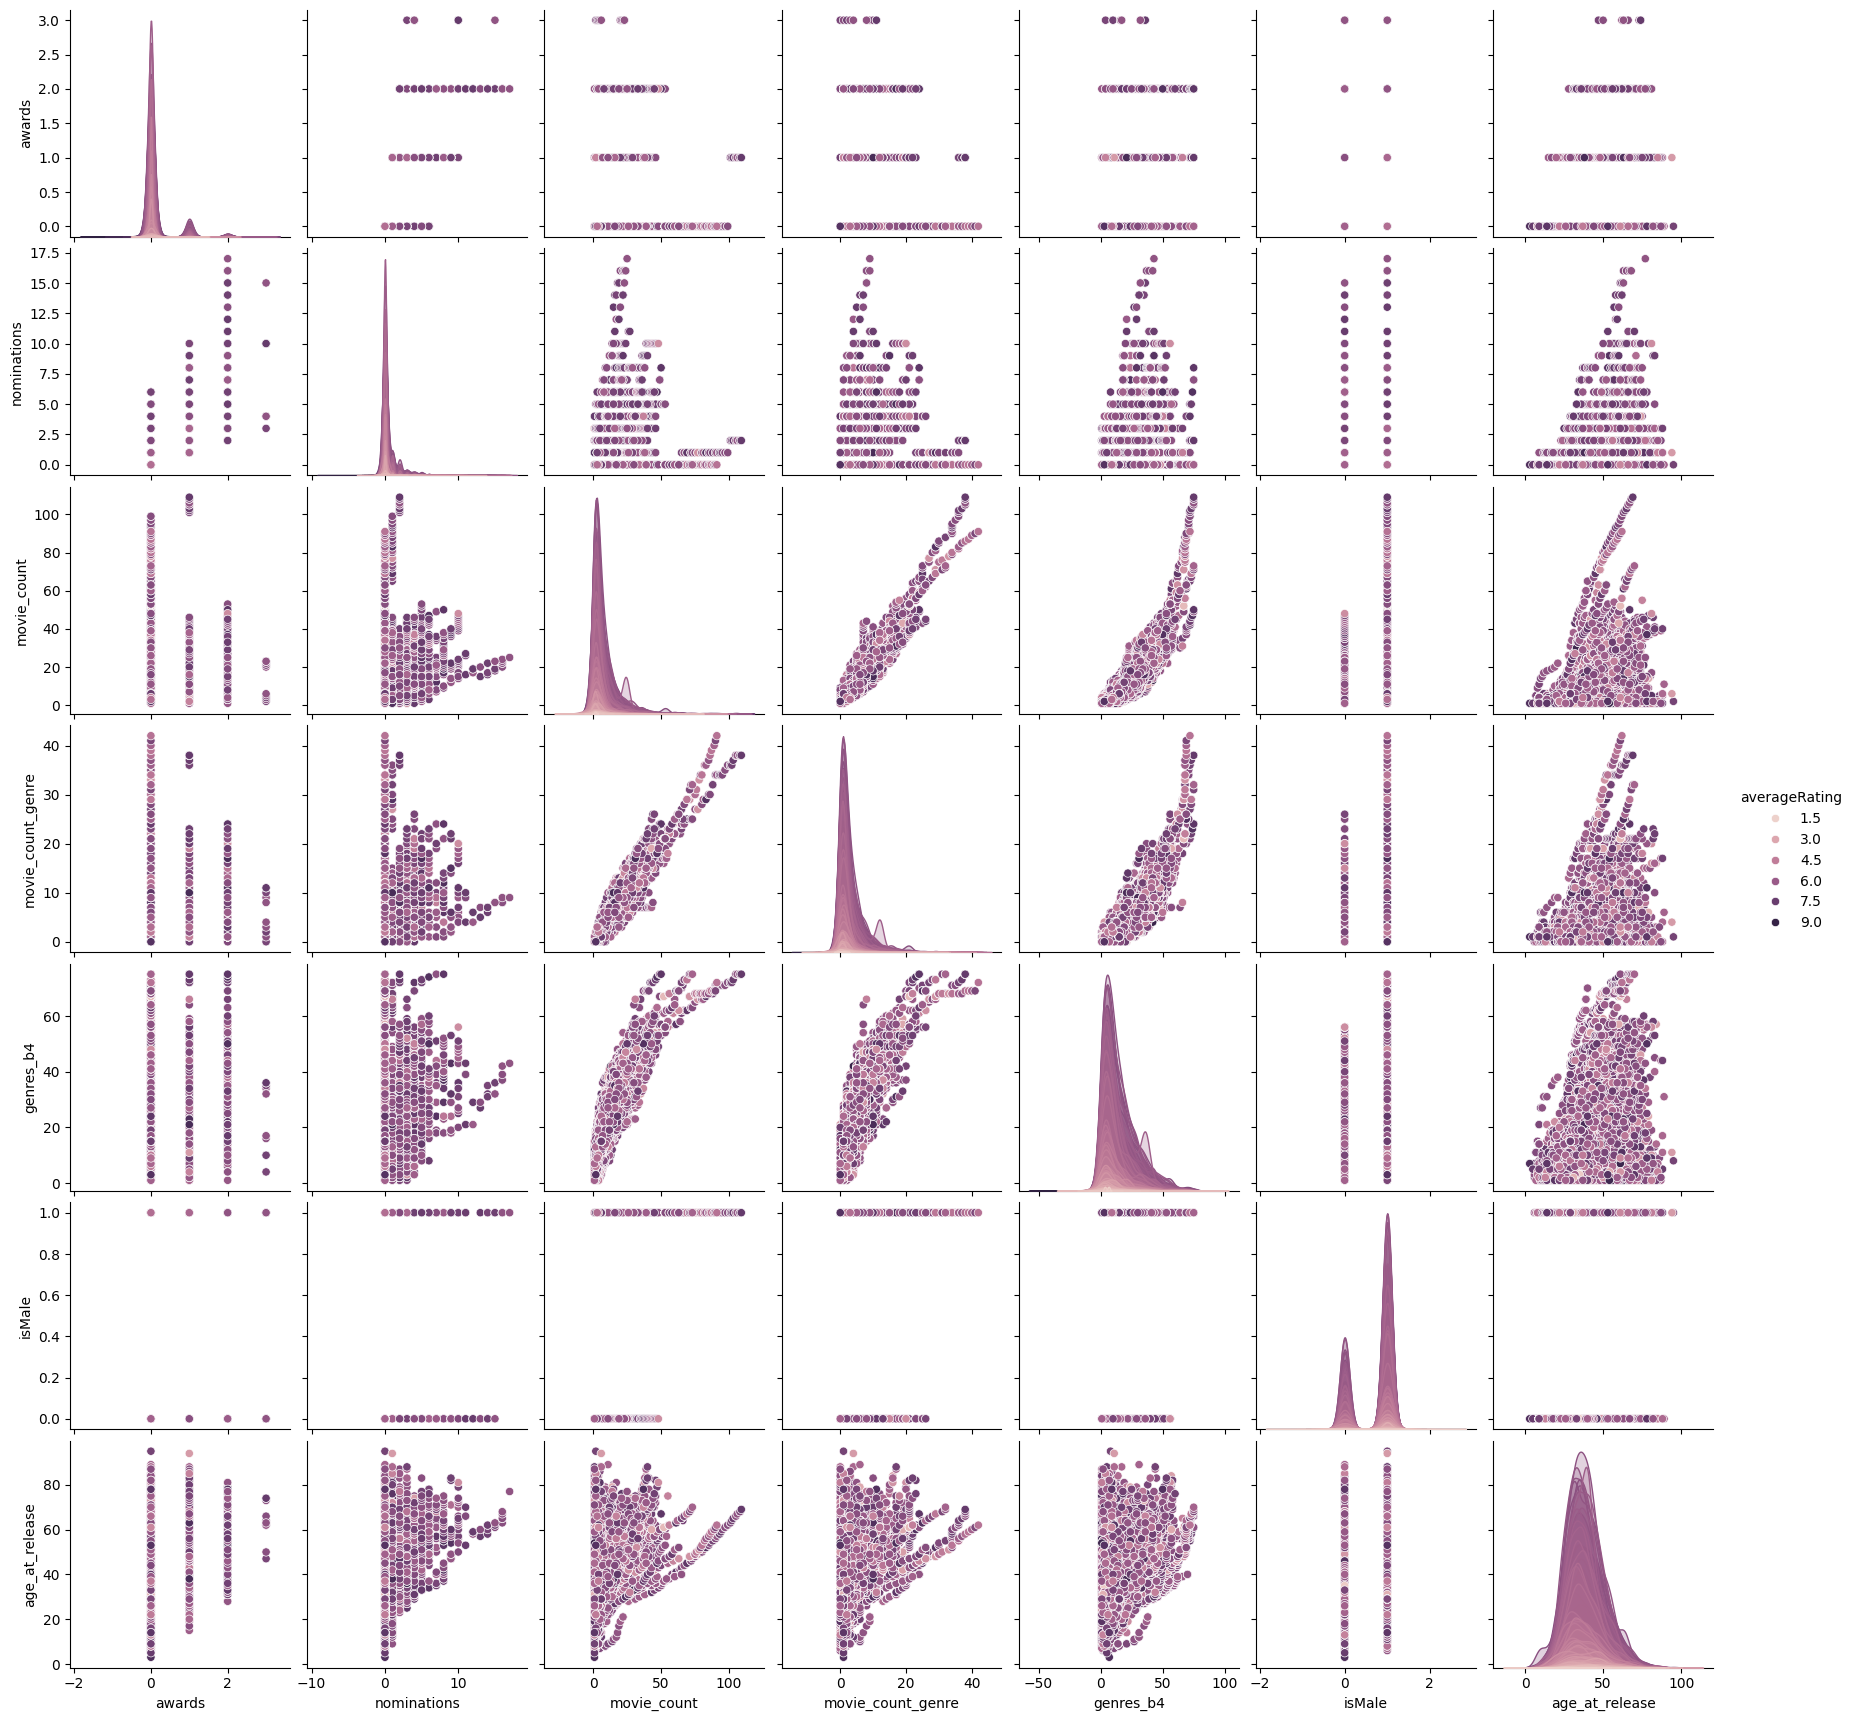

In [15]:
sns.pairplot(tmp[[ 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release', 'averageRating']].dropna(), hue= 'averageRating')